In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

I will be analyzing a new 'dynamic pricing' model that has been recently implemented by a local pest control company in 2021. To briefly describe, the pricing model is for an annual service which is composed of an initial price, followed by monthly reoccurring payments. The original pricing model was simply based on the square footage of the home. With this new dynamic pricing, certain zip codes have increased rates.

There are 3 main data sources which have been pulled form the companies sales records.

1. **Pricing** - An excel spreadsheet that gives pricing for each zip code
2. **Leads** - Information for all created leads which may or may not have generated a sale
3. **Sales** - Invoices for all new accounts

In [2]:
d_pricing_filepath = 'data\dynamic-pricing-2021.xlsx'
lead_filepath = 'data\leads-2021.xlsx'
invoice_filepath = 'data\invoices-2021.xlsx'

In [3]:
df_pricing = pd.read_excel(d_pricing_filepath, dtype={'Zip Code': object})

In [4]:
df_pricing.columns = ['Zip Code', 'State', 'County', 'Towns', 'Initial 2000', 'Monthly 2000', 'Initial 3000', 'Monthly 3000', 'Initial 3500', 'Monthly 3500', 'Initial 4000', 'Monthly 4000', 'Initial 5000', 'Monthly 5000', 'Initial 6000', 'Monthly 6000', 'Initial 7000', 'Monthly 7000']
price_cols = ['Initial 2000', 'Monthly 2000', 'Initial 3000', 'Monthly 3000', 'Initial 3500', 'Monthly 3500', 'Initial 4000', 'Monthly 4000', 'Initial 5000', 'Monthly 5000', 'Initial 6000', 'Monthly 6000', 'Initial 7000', 'Monthly 7000']

In [5]:
df_pricing[price_cols] = round(df_pricing[price_cols], 2)

In [6]:
df_pricing.head()

,Zip Code,State,County,Towns,Initial 2000,Monthly 2000,Initial 3000,Monthly 3000,Initial 3500,Monthly 3500,Initial 4000,Monthly 4000,Initial 5000,Monthly 5000,Initial 6000,Monthly 6000,Initial 7000,Monthly 7000
0,01001,Massachusetts,Hampden,West Springfield Town; Agawam Town,214.99,42.99,229.99,44.99,249.99,47.99,299.99,54.99,399.99,64.99,549.99,64.99,599.99,69.99
1,01002,Massachusetts,Hampshire; Franklin,Pelham; Shutesbury; Amherst,214.99,42.99,229.99,44.99,249.99,47.99,299.99,54.99,399.99,64.99,549.99,64.99,599.99,69.99
2,01003,Massachusetts,Hampshire,Amherst,214.99,42.99,229.99,44.99,249.99,47.99,299.99,54.99,399.99,64.99,549.99,64.99,599.99,69.99
3,01005,Massachusetts,Worcester,Barre,214.99,42.99,229.99,44.99,249.99,47.99,299.99,54.99,399.99,64.99,549.99,64.99,599.99,69.99
4,01007,Massachusetts,Hampshire; Franklin,New Salem; Ware; Belchertown,239.99,47.99,249.99,49.99,289.99,55.99,349.99,65.99,449.99,69.99,689.99,79.99,659.99,76.99


In [7]:
df_pricing.isna().sum()

Zip Code        0
State           0
County          0
Towns           1
Initial 2000    0
Monthly 2000    0
Initial 3000    0
Monthly 3000    0
Initial 3500    0
Monthly 3500    0
Initial 4000    0
Monthly 4000    0
Initial 5000    0
Monthly 5000    0
Initial 6000    0
Monthly 6000    0
Initial 7000    0
Monthly 7000    0
dtype: int64

In [8]:
df_pricing.dtypes

Zip Code         object
State            object
County           object
Towns            object
Initial 2000    float64
Monthly 2000    float64
Initial 3000    float64
Monthly 3000    float64
Initial 3500    float64
Monthly 3500    float64
Initial 4000    float64
Monthly 4000    float64
Initial 5000    float64
Monthly 5000    float64
Initial 6000    float64
Monthly 6000    float64
Initial 7000    float64
Monthly 7000    float64
dtype: object

<br><br>
Lets take a look at the pricing structure, and the distribution of dynamically priced zip codes.
<br><br>

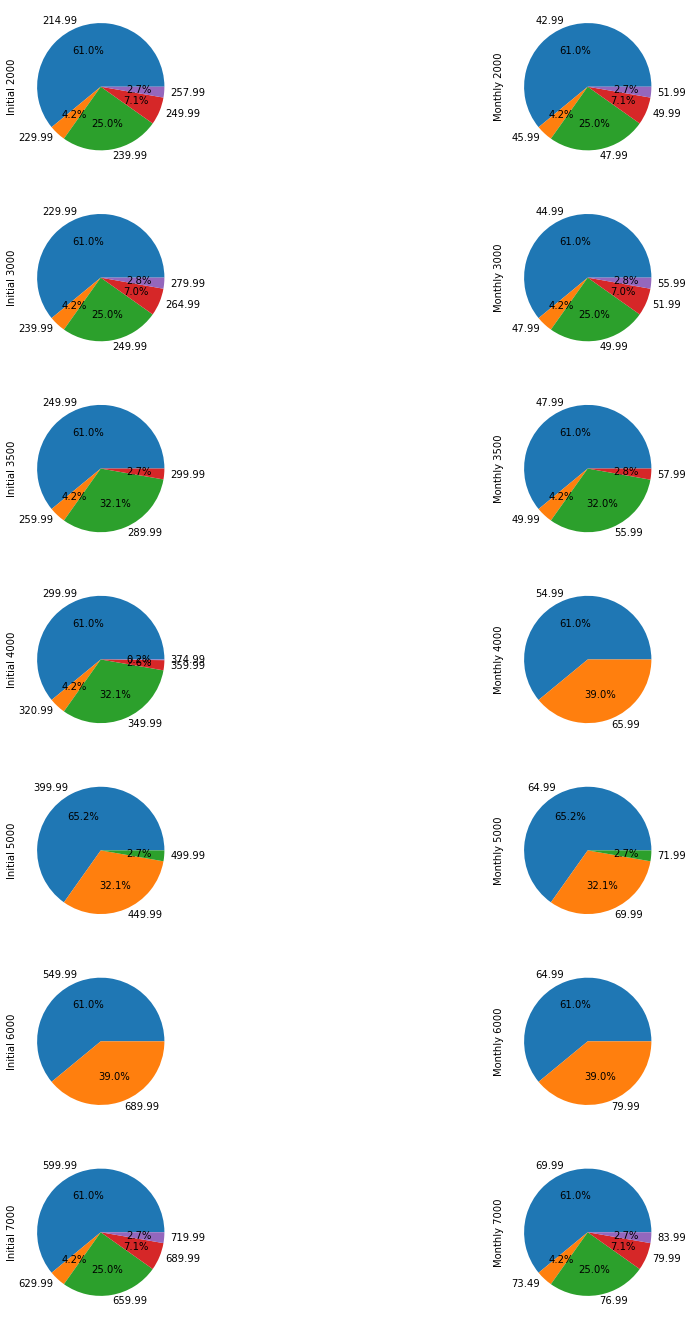

In [9]:
nrows = 7
ncols = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 24))
axe = axes.ravel()


ax_count = 0
for i in range(int(len(price_cols)/2)):
    df_pricing[price_cols[2*i]].value_counts().sort_index().plot(kind='pie', ax=axe[2*i], autopct='%1.1f%%')
    df_pricing[price_cols[2*i + 1]].value_counts().sort_index().plot(kind='pie', ax=axe[2*i + 1], autopct='%1.1f%%')
plt.show();

To simply our analysis we will use the typical pricing structre that we see in the <2000 sq ft home category. We will use the zip codes from this column to categorize each lead and sale as either priced at the standard rate or dynamically priced due to the zip code. We will add a new column 'price_tier' which will be '0' as the lowest pricing option, then 1, 2, 3, and 4 for the increasingly higher pricing tiers.

In [10]:
prices = sorted(df_pricing['Initial 2000'].unique().tolist())
map_prices = {key: value for (value, key) in enumerate(prices)}

In [11]:
df_pricing['price_tier'] = df_pricing['Initial 2000'].map(map_prices)
df_zipcodes = df_pricing[['Zip Code', 'price_tier']]

In [12]:
df_zipcodes.head()

,Zip Code,price_tier
0,01001,0
1,01002,0
2,01003,0
3,01005,0
4,01007,2


<br><br>
So now we have mapped a category based on the prices. We can now use this to categorize each lead and sale based on their zip codes price.

Lets load our lead and invoice data to begin.

In [13]:
df_leads = pd.read_excel(lead_filepath, dtype={'Zip Code': object})
df_invoices = pd.read_excel(invoice_filepath, dtype={'Zip Code': object})

In [14]:
df_leads.head()

,Location,City,State,Zip Code,Won Status,Latitude,Longitude,Received Date,Program,Salesperson,Branch
0,498895,CLINTON,ME,04927-3705,Sold Alternative,44.66038,-69.57509,2021-01-02,HOMECARE,JKEAN,Katahdin
1,498900,LEEDS,ME,04263-3452,Won,44.24209,-70.13676,2021-01-04,HOMECARE,KGISH,Katahdin
2,498899,PORTLAND,ME,04103-2044,Lost,43.70665,-70.29366,2021-01-04,HOMECARE,CMARTIN,Portland
3,498902,PORTLAND,ME,04102-2235,Lost,43.65946,-70.29474,2021-01-04,HOMECARE,KDOCHOD,Portland
4,498904,NORWALK,CT,06853-1026,Won,41.07624,-73.44456,2021-01-04,HOMECARE,CMARTIN,New Haven


In [15]:
df_invoices.head()

,Location,City,State,Zip Code,Latitude,Longitude,Invoice #,Associate,Sold By,Branch,Service,Order Date,Work Date,Sub-Total,Days to Service
0,497900,WESTBROOK,ME,04092-4624,43.701650,-70.337740,4598975,JHARDEN,CTERWEELE,Portland,HC INT RODENT,2020-12-07,2021-01-02,199.0,26
1,498821,KITTERY,ME,03904-1218,43.092901,-70.730190,4616907,AGARMON,CTERWEELE,Portland,HC INT RODENT,2020-12-29,2021-01-02,219.0,4
2,498843,FALMOUTH,ME,04105-1841,43.724210,-70.256150,4617023,AGARMON,CTERWEELE,Portland,HC INT RODENT,2020-12-30,2021-01-02,169.0,3
3,498621,ROCKLAND,ME,04841-2254,44.103830,-69.127360,4616577,ABRADSTREE,SLINGSHOT,Katahdin,HC INT RODENT,2020-12-28,2021-01-04,199.0,7
4,498657,STAMFORD,CT,06902-7447,41.037577,-73.529998,4616687,SMANGANELL,CTERWEELE,New Haven,HC INT RODENT,2020-12-29,2021-01-04,199.0,6


<br><br>
Lets trim our leads list. We are not interested in leads marked as 'Void' as they usually indicate duplicates. We also want to only focus on leads created by members of the inside sales team, so we will remove certain leads based on 'Salesperson'.

In [16]:
df_leads = df_leads[df_leads['Won Status'] != 'Void']

In [17]:
salesperson_keep = ['JKEAN', 'KGISH', 'CMARTIN', 'KDOCHOD', 'BBROUGHAM', 'ZHOLSCLAW',
                    'MCALDWELL','MKONRAD','MSCHEINDEL','LNICHOLS','BIVEY',
                    'CPERRY','EMERRILL', 'LECHEGARAY','TOSBORN','SSTARR','MOJINAGA',
                   'DBODEN','MLESTER','CTERWEELE', 'SLINGSHOT']

In [18]:
df_leads = df_leads[df_leads['Salesperson'].isin(salesperson_keep)]
df_invoices = df_invoices[df_invoices['Sold By'].isin(salesperson_keep)]

<br><br>
First thing I notice is our zip codes are formatted in a different way to include more than just the 5 digit area code. We will remove these extra numbers so that we can join our zip code pricing tiers to the lead and invoice data.

In [19]:
#reformat zip code column for merge with df_zipcodes
df_leads['Zip Code'] = df_leads['Zip Code'].str.split('-', expand=True)[0]
df_invoices['Zip Code'] = df_invoices['Zip Code'].str.split('-', expand=True)[0]

In [20]:
#merge out leads and invoices with zip code df_zipcodes to add the price_tier
df_leads = df_leads.merge(df_zipcodes, on='Zip Code', how='left')
df_invoices = df_invoices.merge(df_zipcodes, on='Zip Code', how='left')

In [21]:
print(df_invoices['price_tier'].isna().sum())
print(df_leads['price_tier'].isna().sum())

34
136


<br><br>
Just a few zip codes are missing from our dynamic pricing sheet. We will fill these missing values in as 0. Then we will convert to integers.

In [22]:
df_leads['price_tier'] = df_leads['price_tier'].fillna(0).astype('int')
df_invoices['price_tier'] = df_invoices['price_tier'].fillna(0).astype('int')

In [23]:
df_leads.isna().sum()

Location          0
City              1
State             1
Zip Code          0
Won Status        0
Latitude         21
Longitude        21
Received Date     0
Program           0
Salesperson       0
Branch            0
price_tier        0
dtype: int64

In [24]:
df_leads[df_leads['City'].isna()].index

Int64Index([9308], dtype='int64')

In [25]:
#removing this lead whihch has no branch information and thus is not of value
df_leads.drop(labels=df_leads[df_leads['City'].isna()].index, inplace=True)

<br>
The missing values in our long/lat columns will not effect analysis.

In [26]:
df_invoices.isna().sum()

Location           0
City               0
State              0
Zip Code           0
Latitude           0
Longitude          0
Invoice #          0
Associate          0
Sold By            0
Branch             0
Service            0
Order Date         0
Work Date          0
Sub-Total          0
Days to Service    0
price_tier         0
dtype: int64

<br>
I will filter out leads that were recently created since the company is frequently scheduling out services 2+ weeks. Also, invoices that were sold in 2020 will be removed as well.

In [27]:
#filter out invoices that were sold in 2020 or 
df_invoices = df_invoices[(df_invoices['Order Date'] > '2021-1-1')]

#filter out leads that were started after mid October
df_leads = df_leads[(df_leads['Received Date'] > '2021-1-1') & (df_leads['Received Date'] < '2021-10-14')]

In [28]:
#drop leads marked as 'Sold Alternative'
index_names = df_leads[(df_leads['Won Status'] == 'Sold Alternative') | (df_leads['Branch'] == 'Brunswick') | (df_leads['Won Status'] == 'Void')].copy().index
df_leads.drop(index_names, inplace=True)

In [29]:
#create month column for analysis
df_invoices['Month'] = df_invoices['Order Date'].dt.month
df_leads['Month'] = df_leads['Received Date'].dt.month

<br><br>
The last feature I will need to encode is found in the invoice column 'Days to Service'. This is a measure of how long it took for the service to be completed once it had been sold. A large value is due to staffing issues. Long waits are expected to decrease sales as most customers have time sensitive problems. I will compute these values per branch and for each month. 

In [30]:
df_branch_eta = df_invoices.groupby(['Branch', 'Month']).median().reset_index()[['Branch', 'Month', 'Days to Service']]

In [31]:
df_branch_eta.head()

,Branch,Month,Days to Service
0,Boston,1,4.0
1,Boston,2,3.5
2,Boston,3,5.5
3,Boston,4,8.0
4,Boston,5,4.0


In [ ]:
df_zipcodes.to_excel('data\zipcodes_cleaned.xlsx')
df_invoices.to_excel('data\invoices_cleaned.xlsx')
df_invoices.to_excel('data\invoices_cleaned.xlsx')